# L4: Automate Event Planning

In this lesson, you will learn more about Tasks.

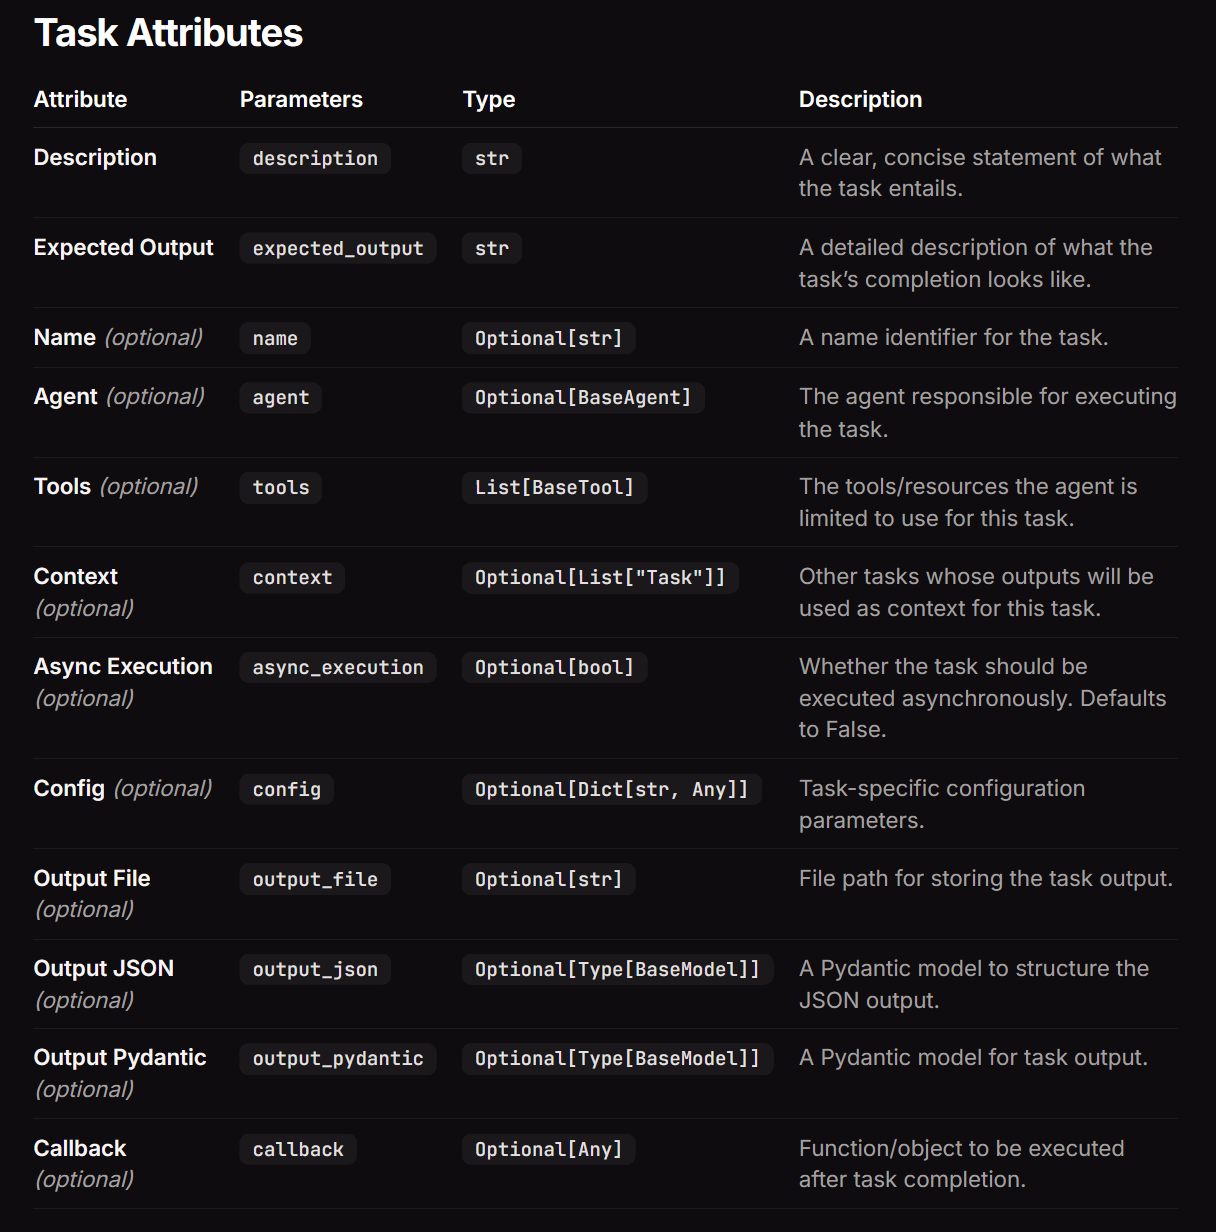

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, APIs and LLM

In [ ]:
from crewai import Agent, Crew, Task

**Note**:
- The video uses `gpt-4-turbo`, but due to certain constraints, and in order to offer this course for free to everyone, the code you'll run here will use `gpt-3.5-turbo`.
- You can use `gpt-4-turbo` when you run the notebook _locally_ (using `gpt-4-turbo` will not work on the platform)
- Thank you for your understanding!

In [ ]:
import os
from utils import get_openai_api_key,get_serper_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["SERPER_API_KEY"] = get_serper_api_key()

## crewAI Tools

In [ ]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

## Creating Agents

In [ ]:
# Agent 1: Venue Coordinator
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue "
    "based on event requirements",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "With a keen sense of space and "
        "understanding of event logistics, "
        "you excel at finding and securing "
        "the perfect venue that fits the event's theme, "
        "size, and budget constraints."
    )
)

In [ ]:
 # Agent 2: Logistics Manager
logistics_manager = Agent(
    role='Logistics Manager',
    goal=(
        "Manage all logistics for the event "
        "including catering and equipmen"
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, "
        "you ensure that every logistical aspect of the event "
        "from catering to equipment setup "
        "is flawlessly executed to create a seamless experience."
    )
)

In [ ]:
# Agent 3: Marketing and Communications Agent
marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Effectively market the event and "
         "communicate with participants",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, "
        "you craft compelling messages and "
        "engage with potential attendees "
        "to maximize event exposure and participation."
    )
)

## Creating Venue Pydantic Object

- Create a class `VenueDetails` using [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/).
- Agents will populate this object with information about different venues by creating different instances of it.

In [ ]:
from pydantic import BaseModel
# Define a Pydantic model for venue details
# (demonstrating Output as Pydantic)
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

## Creating Tasks
- By using `output_json`, you can specify the structure of the output you want.
- By using `output_file`, you can get your output in a file.
- By setting `human_input=True`, the task will ask for human feedback (whether you like the results or not) before finalising it.

In [ ]:
venue_task = Task(
    description="Find a venue in {event_city} "
                "that meets criteria for {event_topic}.",
    expected_output="All the details of a specifically chosen"
                    "venue you found to accommodate the event.",
    human_input=True,
    output_json=VenueDetails,
    output_file="venue_details.json",
      # Outputs the venue details as a JSON file
    agent=venue_coordinator
)

- By setting `async_execution=True`, it means the task can run in parallel with the tasks which come after it.

Integrating CrewAI with human input during execution in complex decision-making processes and leveraging the full capabilities of the agent’s attributes and tools.

with human_input=True, Before it is completed, it will ask us whether we want to give some infoemation or ....?

In [ ]:
logistics_task = Task(
    description="Coordinate catering and "
                 "equipment for an event "
                 "with {expected_participants} participants "
                 "on {tentative_date}.",
    expected_output="Confirmation of all logistics arrangements "
                    "including catering and equipment setup.",
    human_input=True,
    async_execution=True,
    agent=logistics_manager
)

In [ ]:
marketing_task = Task(
    description="Promote the {event_topic} "
                "aiming to engage at least"
                "{expected_participants} potential attendees.",
    expected_output="Report on marketing activities "
                    "and attendee engagement formatted as markdown.",
    async_execution=True,
    output_file="marketing_report.md",  # Outputs the report as a text file
    agent=marketing_communications_agent
)

## Creating the Crew

**Note**: Since you set `async_execution=True` for `logistics_task` and `marketing_task` tasks, now the order for them does not matter in the `tasks` list.

In [ ]:
# Define the crew with agents and tasks
event_management_crew = Crew(
    agents=[venue_coordinator,
            logistics_manager,
            marketing_communications_agent],

    tasks=[venue_task,
           logistics_task,
           marketing_task],

    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [ ]:
event_details = {
    'event_topic': "Tech Innovation Conference",
    'event_description': "A gathering of tech innovators "
                         "and industry leaders "
                         "to explore future technologies.",
    'event_city': "San Francisco",
    'tentative_date': "2024-09-15",
    'expected_participants': 500,
    'budget': 20000,
    'venue_type': "Conference Hall"
}

**Note 1**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

**Note 2**:
- Since you set `human_input=True` for some tasks, the execution will ask for your input before it finishes running.
- When it asks for feedback, use your mouse pointer to first click in the text box before typing anything.

In [ ]:
result = event_management_crew.kickoff(inputs=event_details)

- Display the generated `venue_details.json` file.

In [ ]:
import json
from pprint import pprint

with open('venue_details.json') as f:
   data = json.load(f)

pprint(data)

- Display the generated `marketing_report.md` file.

**Note**: After `kickoff` execution has successfully ran, wait an extra 45 seconds for the `marketing_report.md` file to be generated. If you try to run the code below before the file has been generated, your output would look like:

```
marketing_report.md
```

If you see this output, wait some more and than try again.

In [ ]:
from IPython.display import Markdown
Markdown("marketing_report.md")